In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from numpy.random import Generator, SFC64
from torch.utils.data import Dataset , DataLoader
from sklearn.datasets import fetch_olivetti_faces

In [ ]:
rng = Generator(SFC64(12345))

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
class OlivettiFaces(Dataset):
  def __init__(self, data_path='/content/Data'):
    (self.data, self.target) = fetch_olivetti_faces(data_home=data_path, shuffle=False, download_if_missing=True, return_X_y=True)

  def __len__(self):
    return len(self.target)

  def __getitem__(self, index):
    if index%2 == 0:
      idx = rng.integers(low=index-index%10, high=index-index%10+10)
      img1 = self.data[idx].reshape(1,64,64)
      img2 = self.data[index].reshape(1,64,64)
      return (torch.from_numpy(img1), torch.from_numpy(img2), torch.tensor(0, dtype=torch.float32))
    else:
      idx = rng.integers(low=0, high=400)
      while (idx >= index-index%10 and idx <= index-index%10+10):
        idx = rng.integers(low=0, high=400)
      img1 = self.data[idx].reshape(1,64,64)
      img2 = self.data[index].reshape(1,64,64)
      return (torch.from_numpy(img1), torch.from_numpy(img2), torch.tensor(1, dtype=torch.float32))

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.CNN = nn.Sequential(
        nn.Conv2d(1, 2, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(2),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),

        nn.Conv2d(2, 4, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),

        nn.Conv2d(4, 8, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3)
    )

    self.FCNN = nn.Sequential(
        nn.Linear(64*64*8, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 16)
    )

  def forward(self, img1, img2):
    out1 = self.CNN(img1)
    out1 = torch.flatten(out1, start_dim=1)
    out1 = self.FCNN(out1)
    out2 = self.CNN(img2)
    out2 = torch.flatten(out2, start_dim=1)
    out2 = self.FCNN(out2)
    return out1, out2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.5):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [ ]:
params = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 2}

In [ ]:
dataset = OlivettiFaces('/content/Data')
dataloader = DataLoader(dataset, **params)

In [ ]:
model = Model()
model = model.to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
loss_func = []
for epoch in range(100):
  model.train()
  for t, (img1,img2,tgt) in enumerate(dataloader):
    if t<6:
      img1, img2, tgt = img1.to(device), img2.to(device), tgt.to(device)
      out1, out2 = model(img1,img2)
      loss = criterion(out1, out2, tgt)
      loss_func.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      model.eval()
      img1, img2, tgt = img1.to(device), img2.to(device), tgt.to(device)
      with torch.no_grad():
        out1, out2 = model(img1,img2)
      euc_sim = F.pairwise_distance(out1, out2)
  if epoch%10 == 0:
    print("LOSS:",float(loss))

LOSS: 0.6369757056236267
LOSS: 0.5909295082092285
LOSS: 0.5789825916290283
LOSS: 0.584187924861908
LOSS: 0.5788142681121826
LOSS: 0.578057050704956
LOSS: 0.5789229869842529
LOSS: 0.5753463506698608
LOSS: 0.5820393562316895
LOSS: 0.5768009424209595


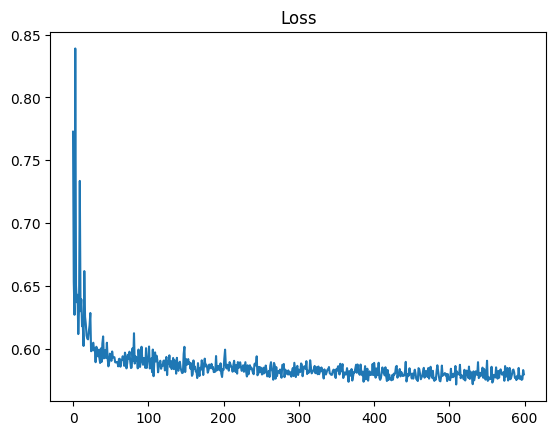

In [ ]:
plt.plot(loss_func)
plt.title("Loss")
plt.show()

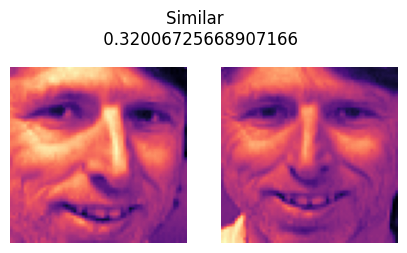

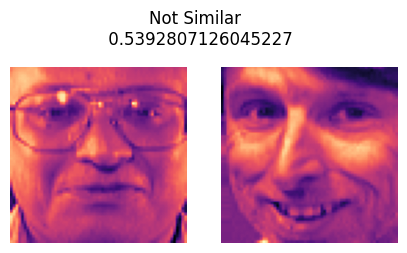

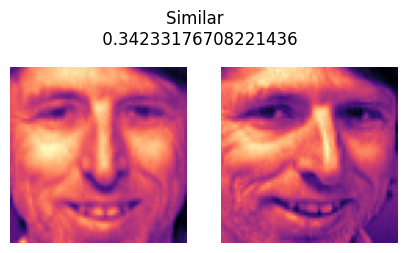

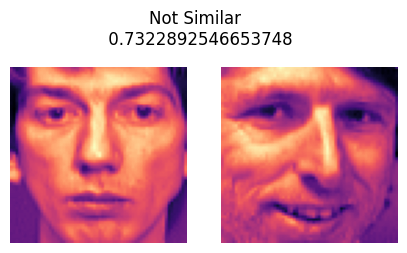

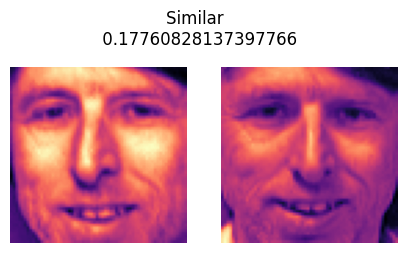

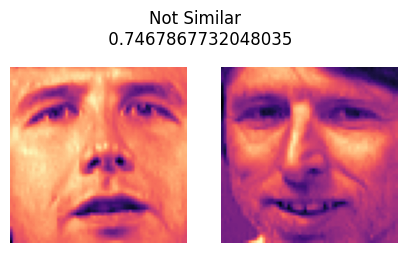

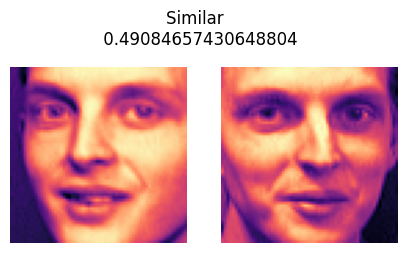

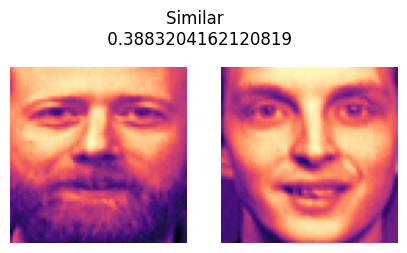

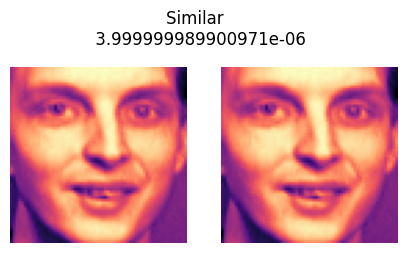

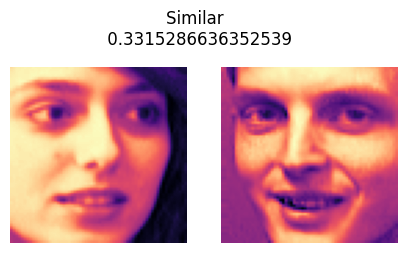

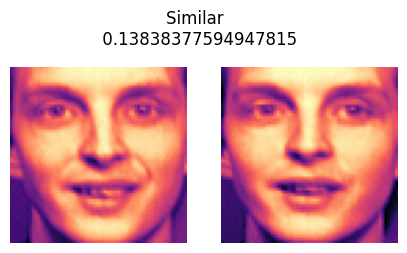

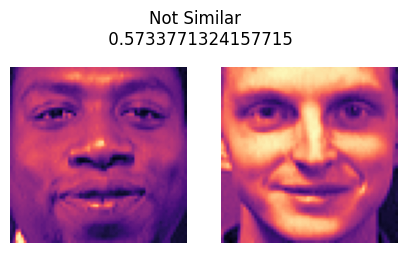

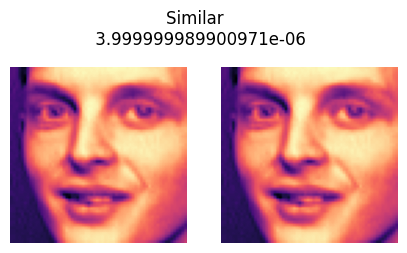

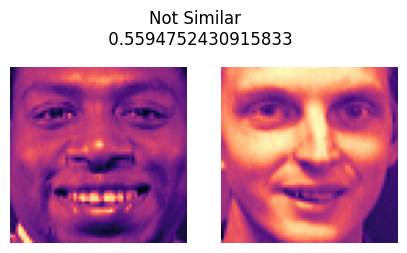

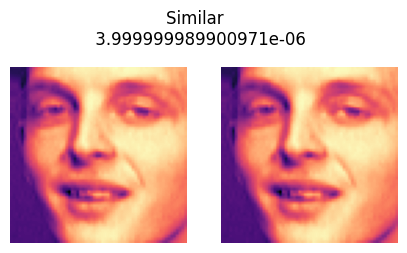

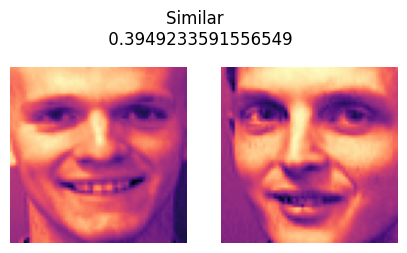

In [ ]:
for idx in range(16):
  imag1 = img1[idx].cpu().numpy()
  imag2 = img2[idx].cpu().numpy()
  fig = plt.figure(figsize=(5,3))
  fig.add_subplot(1, 2, 1)
  plt.imshow(np.transpose(imag1, (1, 2, 0)), cmap='magma')
  plt.axis('off')
  fig.add_subplot(1, 2, 2)
  plt.imshow(np.transpose(imag2, (1, 2, 0)), cmap='magma')
  plt.axis('off')
  if float(euc_sim[idx]) > 0.5:
    title = 'Not Similar \n {}'
  else:
    title = 'Similar \n {}'
  fig.suptitle(title.format(float(euc_sim[idx])))